In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
import LCDMSphere
import Energy_loss_class
import Source_class

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G

nstep = 199 # redshift grid
mstep = 199 # energy grid

In [2]:
# calculate overdensity evolution
C = LCDMSphere.XCosmo(0.6774, 0.319)
C.overdensity_evol(15., -10., nstep+1)
z_list = C.z_grid # redshift grid
delta_b = C.Delta_grid # overdensity of baryon
Delta_list = np.array([1 + x for x in delta_b]) # relative overdensity of baryon - grid
ln_Delta = [np.log(x) for x in Delta_list]

dDdz = np.zeros((nstep, )) # d ln(Delta)/dz
for i in range(nstep):
    dDdz[i] = (ln_Delta[i+1] - ln_Delta[i]) / (z_list[i+1] - z_list[i])

z = (z_list[:-1] + z_list[1:]) / 2 # midpoint of z grid, correspond to d ln(Delta)/dz
    
Delta = (Delta_list[:-1] + Delta_list[1:]) / 2 # midpoint of overdensity grid, correspond to d ln(Delta)/dz
    
H = np.zeros((nstep, ))
for i in range(nstep):
    H[i] = C.H(z[i])
    
theta = np.zeros((nstep, ))
for i in range(nstep):
    theta[i] = 3 * H[i] - dDdz[i]

In [3]:
# coefficient of dN(E, t)/dE
def A2(E, z, Delta_i, theta_i, H):
    loss = Energy_loss_class.Loss(z, E, Delta_i)
    co1 = theta_i / 3 * E * (E + 2 * E_e) / (E + E_e)
    co2 = loss.E_loss()
    co = (co1 - co2) / (-(1 + z) * H)
    return co1 - co2

In [4]:
# coefficient due to secondary electron
def A3(E, E_p, z, H): # E_p means E_prime
    omega_b = omega_b_0 * (1 + z)**3
    n_H = 0.76 * omega_b * rho_crit / m_p
    n_etot = n_H * (1 + 2 * f_He)
    beta_p = np.sqrt(E_p * (E_p + 2 * E_e)) / (E_p + E_e)
    co1 = 2 * np.pi * r0 * r0 * E_e * (E_e + E_p)**2 / E_p / (2 * E_e + E_p) / E / E
    co2 = 1 + E * E / (E_p - E)**2 + E * E / (E_e + E_p)**2 - E_e * (E_e + 2 * E_p) * E/ (E_e + E_p)**2 / (E_p - E)
    return n_etot * c * beta_p * co1 * co2 / (-(1 + z) * H)

In [5]:
E_min = 1e-8 # temp, in erg
E_max = 1e-3 # temp, in erg

E = np.logspace(np.log10(E_min), np.log10(E_max), mstep + 1)

E_mid = (E[:-1] + E[1:]) / 2
E_p = np.zeros((mstep+1, 1)) # E_{i+1/2} = sqrt(E[i] * E[i+1])
E_m = np.zeros((mstep+1, 1)) # E_{i-1/2} = sqrt(E[i-1] * E[i])

for i in range(mstep):
    E_p[i] = np.sqrt(E[i] * E[i+1]) # length len(E) -1

dlnE = np.log(E[-1] / E[-2])
E_p[-1] = E_p[-2] * np.exp(dlnE)

for i in range(1, mstep+1):
    E_m[i] = np.sqrt(E[i] * E[i-1])
    
dlnE = np.log(E[1] / E[0])
E_m[0] = E_m[1] / np.exp(dlnE)

In [6]:
S = np.loadtxt("source_term.txt") # in 'same columns, same redshift; same row, same energy' format 
S = np.delete(S, 0, axis=1) 
Sz = [[S[i][j] / (-(1 + z[j]) * H[j]) for j in range(nstep)] for i in range(mstep)]

In [7]:
def get_M(z, Delta, theta, H): # parameters that only depend on redshift
    M = np.zeros((mstep, mstep))

    for i in range(mstep):
        for j in range(mstep):
            if j == i or j == i-1 or j == i+1:
                A1_ij = -theta / (-(1 + z) * H)
        
                A2_ij = A2(E[j], z, Delta, theta, H)
                A2_ij_p = A2(E_p[j], z, Delta, theta, H)
                A2_ij_m = A2(E_m[j], z, Delta, theta, H)
        
                dE = E[j+1] - E[j]
                dE_p = E_p[j+1] - E_p[j]
                dE_m = E_m[j+1] - E_m[j]
        
                if j == i:
                    M[i][j] += A1_ij + A2_ij_p * (1/2/dE_p - 1/dE) - A2_ij_m * (1/2/dE_m - 1/dE)
                if j == i-1:
                    M[i][j] -= A2_ij_m / 2 / dE_m
                if j == i+1:
                    M[i][j] += A2_ij_p / 2 / dE_p
                
            if E[j] >= 2 * E[i]:
                M[i][j] += A3(E[i], E[j], z, H)
                
    return M

In [8]:
SdE = [[Sz[i][j]*(E[i+1]-E[i]) for j in range(nstep)] for i in range(mstep)]

In [9]:
def back_Euler(SdE): # solve dN/dz = MN + S using backward Euler method, M is square matrix, S is column vector
    n = np.zeros((mstep, 1))
    I = np.identity(mstep)
    
    for j in range(1, nstep):
        n_jm = np.zeros((mstep,1)) # partition column vector with redshift z[j-1]
        for i in range(mstep):
            n_jm[i] = n[i][j-1]
        
        dz = z[j] - z[j-1]
        
        S_j = np.zeros((mstep, 1))
        for i in range(mstep):
            S_j[i] = SdE[i][j]
            
        M_j = get_M(z[j], Delta[j], theta[j], H[j]) # M matrix only depend on redshift
        
        dzS = np.dot(dz, S_j)
        n_jm_plus_dzS = np.zeros((mstep,1))
        for i in range(mstep):
            n_jm_plus_dzS[i] = n_jm[i]+dzS[i]
            
        dzM = np.dot(dz, M_j)
        I_minus_dzM = np.zeros((mstep,mstep))
        for i in range(mstep):
            for k in range(mstep):
                I_minus_dzM[i][k] = I[i][k]-dzM[i][k]
                
        I_m_inv = np.linalg.inv(I_minus_dzM)
        
        n_j = np.dot(I_m_inv, n_jm_plus_dzS)
    
        n = np.hstack((n,n_j))
        
    return n

In [10]:
n = back_Euler(SdE)

In [11]:
N = np.zeros((mstep, nstep))
for i in range(mstep):
    for j in range(nstep):
        N[i][j] = n[i][j] / (E[i+1] - E[i])

<AxesSubplot:>

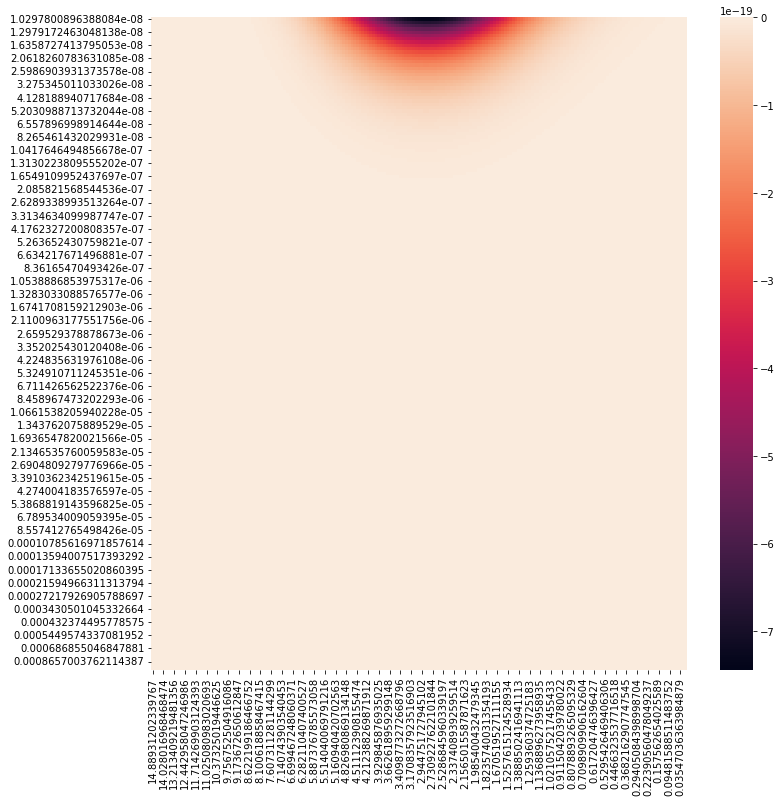

In [17]:
N_data = pd.DataFrame(data=N, index=E_mid, columns=z)
plt.figure(figsize = (12,12))
sns.heatmap(N_data)

In [20]:
print(z)

[1.48893120e+01 1.46694675e+01 1.44526648e+01 1.42388618e+01
 1.40280170e+01 1.38200894e+01 1.36150387e+01 1.34128250e+01
 1.32134092e+01 1.30167525e+01 1.28228168e+01 1.26315643e+01
 1.24429580e+01 1.22569613e+01 1.20735380e+01 1.18926526e+01
 1.17142699e+01 1.15383553e+01 1.13648747e+01 1.11937943e+01
 1.10250810e+01 1.08587020e+01 1.06946250e+01 1.05328182e+01
 1.03732502e+01 1.02158899e+01 1.00607069e+01 9.90767101e+00
 9.75675250e+00 9.60792211e+00 9.46115093e+00 9.31641048e+00
 9.17367265e+00 9.03290975e+00 8.89409444e+00 8.75719977e+00
 8.62219919e+00 8.48906647e+00 8.35777577e+00 8.22830161e+00
 8.10061886e+00 7.97470272e+00 7.85052876e+00 7.72807287e+00
 7.60731128e+00 7.48822055e+00 7.37077755e+00 7.25495950e+00
 7.14074390e+00 7.02810859e+00 6.91703171e+00 6.80749168e+00
 6.69946725e+00 6.59293744e+00 6.48788158e+00 6.38427927e+00
 6.28211041e+00 6.18135515e+00 6.08199394e+00 5.98400749e+00
 5.88737679e+00 5.79208306e+00 5.69810782e+00 5.60543282e+00
 5.51404007e+00 5.423911

In [21]:
print(S)

[[3.66987273e-28 8.12009354e-28 1.38690418e-27 ... 5.91294592e-23
  5.32664408e-23 4.78300354e-23]
 [3.34493288e-28 7.40102269e-28 1.26404323e-27 ... 5.31753067e-23
  4.78942534e-23 4.29976559e-23]
 [3.04669911e-28 6.74105828e-28 1.15128473e-27 ... 4.77919210e-23
  4.30381818e-23 3.86306743e-23]
 ...
 [8.06251921e-41 1.78360071e-40 3.04484418e-40 ... 1.28134391e-35
  1.15671638e-35 1.04110291e-35]
 [6.77669077e-41 1.49914805e-40 2.55924531e-40 ... 1.07691547e-35
  9.72169526e-36 8.74999685e-36]
 [5.70014065e-41 1.26099222e-40 2.15268138e-40 ... 9.05768324e-36
  8.17667443e-36 7.35938787e-36]]


In [22]:
print(Sz)

[[-2.940239819335006e-13, -6.736200251797705e-13, -1.1913034796653305e-12, -2.2156658085489096e-12, -3.2115329448325848e-12, -5.774931402803629e-12, -8.510286775641155e-12, -1.3347840026909093e-11, -2.0865920948140195e-11, -2.8174155631043542e-11, -4.7559027037751246e-11, -6.754086734830775e-11, -9.790213477503199e-11, -1.5212176434355742e-10, -2.0482734937066443e-10, -3.1203522475711834e-10, -4.538040114538826e-10, -5.916051012642275e-10, -9.150515174946468e-10, -1.2821442416985332e-09, -1.638945252587206e-09, -2.5122944352576753e-09, -3.4527723601038157e-09, -4.366852123040988e-09, -6.4938688620821215e-09, -8.875456841716398e-09, -1.1190157641545161e-08, -1.4734221776293618e-08, -1.9610146283456838e-08, -2.5806759804499982e-08, -3.4602773169837596e-08, -4.572940741786913e-08, -5.9382780138921105e-08, -7.743223365972818e-08, -1.0133496336436833e-07, -1.3019695332973142e-07, -1.6620337152017838e-07, -2.1482929003118666e-07, -2.7216752520664624e-07, -3.431959907564295e-07, -4.3686615971

In [18]:
NE = np.zeros((nstep, ))
for i in range(mstep):
    NE[i] = 0
    for j in range(nstep):
        NE[i] += E[i] * N[i][j]

In [12]:
NE = np.zeros((mstep, nstep))
for i in range(mstep):
    for j in range(nstep):
        NE[i][j] = E_mid[i] * E_mid[i] * N[i][j]

In [13]:
NE_data = pd.DataFrame(data=NE, index=E_mid, columns=z)

<AxesSubplot:>

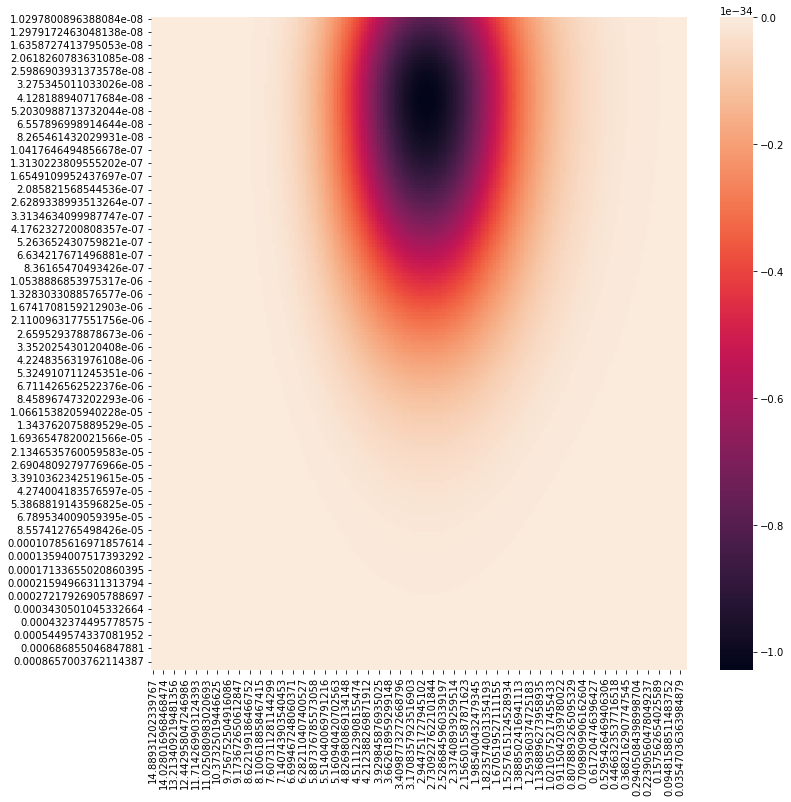

In [14]:
plt.figure(figsize = (12,12))
sns.heatmap(NE_data)